<a href="https://colab.research.google.com/github/zakaria-aabbou/Covid_19_topic_modeling/blob/main/2_COVID_19_topic_modeling_cc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Topic Modeling and literature search engine
__________________________________


## Context:
Just a few months ago, 2020 was believed to be as normal of a year as any other year. But then, COVID-19 happened, and it has been disrupting life in an unbelievable way. There has been so much news about COVID-19, but not all of them are reliable. In order to really understand the virus and different risk factors, it’s important to read and use scientific facts. 

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 52,000 scholarly articles, including over 41,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. 

With 52,000 articles available, it would be very challenging for someone who only wants to explore a particular topic to have to browse through all articles and find relevant documents. Therefore,in this notebook, we would like to implement an engine that allows viewers to explore different information related to COVID-19 based on the viewer’s topics of interest. These topics can range from: what do we know about COVID-19 risk factors?, what do we know about virus genetics, origin, and evolution?, to what do we know about diagnostics and surveillance?, and so on.

## About the dataset:
CORD-19 is a resource of over 59,000 scholarly articles, including over 47,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. 

This dataset was created by the Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.

The original dataset includes multiple files(.csv files,.text files, and .json files that contain the research paper litureratures). In a separate notebook, we have done all the data loading and cleaning work in order to create a clean dataset that we'll be using in this notebook. The data loading and cleaning notebook can be found within the same directory under "Load & clean data files". After extracting the data, engineering new features, imputing the data, and removing duplicates, we ended up with a clean dataset with 41,948 records that will be used below.

## Goal and application:
The goal of this project is to build an automated engine that allows viewers to search for relevant articles related to their topics of research. This solution allows people who are interested in learning more about the COVID-19 virus to filter through over 40,000 articles quickly to find only information that they’re interested in. For example, a viewer can have a specific research question about COVID-19 vaccines and only want to read  relevant articles related to that topic.

This engine can also be applied in the real world in many different situations. It can be used as a search engine(similar to Google search) that filters to show only relevant news/articles. Imagine information services like EBSCO, who provide research databases, can take advantage of a system like this to allow viewers to search for related publications for a topic of interest.

## Notebook content:
Below is the breakout of this notebook:

**1. Import libraries and load the dataset**

**2. Exploratory Data Analysis (EDA)**

* Statistical analysis
* Language detection
* Visualizations

**3. Text preprocessing**
* Standard text cleaning
* Tokenization, Lemmantization, and Vectorization

**4. Text clustering with KMeans**

**5. Topic exploration with LSA, LDA, and NMF**
* LSA, LDA, NMF topic exploring
* Compare models

**6. Build literature search engine**
* Topic similarity using cosine metric
* Build liturerature searching engine 
    
**7. Conclusion**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Import libraries and load the dataset

In [ ]:
# !pip install chart_studio
# !pip install scispacy
# !pip install -U spacy
#A full spaCy pipeline for biomedical data with a larger vocabulary and 600k word vectors.
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz 
# !pip install langdetect

In [ ]:
# Import libraries:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import joblib

# Libraries for interactive visualization:
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Libraries for natural language processing:
import re
import nltk
import sklearn
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from scipy.spatial.distance import cdist, cosine

import scispacy
import en_core_sci_lg
import spacy
!python -m spacy download en

# Libraries to detect language:
from langdetect import detect
from langdetect import DetectorFactory

# Libraries for interactive widgets:
from IPython.display import HTML, display
from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.7 MB 14.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Shared_data/kaggle_covid-19_clean_format.csv'

In [ ]:
# Load the dataset and print out the first 5 rows of the dataset:
covid19 = pd.read_csv(path, index_col=0)
covid19.head()

,paper_id,source_x,title,license,abstract,journal,body_text,body_word_count,url,publish_year
0,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,no-cc,Inflammatory diseases of the respiratory tract...,Respir Res,Since its discovery as a biological messenger ...,3093,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,2000
1,f1d1b9694aa43c837d9b758cb2d45d8a24d293e3,PMC,Detection and characterization of horizontal t...,no-cc,Horizontal DNA transfer is an important factor...,Nucleic Acids Res,It is now widely admitted that actual genomes ...,6369,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,2005
2,867e1b0f6ca8757f2a32a625d99b23888ab40d49,PMC,"Comparisons of substitution, insertion and del...",no-cc,Although oligonucleotide probes complementary ...,Nucleic Acids Res,Oligonucleotide microarrays are a powerful tec...,3833,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,2005
3,b022e6ee1e7b9a0a822b1255c2fa12f81ddc52fd,PMC,A Gene Encoding Sialic-Acid-Specific 9-O-Acety...,no-cc,"Using differential display RT-PCR, we identifi...",J Biomed Biotechnol,Sialic acids are a diverse family of acidic ni...,2944,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,2004
4,03203ab50eb64271a9e825f94a1b1a6c46ea14b3,PMC,Recombination Every Day: Abundant Recombinatio...,cc-by,Viral recombination can dramatically impact ev...,PLoS Biol,As increasing numbers of full-length viral seq...,4867,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,2005


In [ ]:
covid19 = covid19[covid19.publish_year != 'NaT']

In [ ]:
# Change datatypes of month and year features:
covid19['publish_year'] = covid19['publish_year'].astype('int64')

In [ ]:
covid19 = covid19[covid19['url'].notna()]

In [ ]:
# Inspect column datatype and missing values:
covid19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83788 entries, 0 to 116722
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paper_id         83788 non-null  object
 1   source_x         83788 non-null  object
 2   title            83788 non-null  object
 3   license          83788 non-null  object
 4   abstract         83788 non-null  object
 5   journal          83788 non-null  object
 6   body_text        83788 non-null  object
 7   body_word_count  83788 non-null  int64 
 8   url              83788 non-null  object
 9   publish_year     83788 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 7.0+ MB


We are looking at 10 features and 83,788 rows in the covid19 dataset. Since the majority of the cleaning has been done in a different notebook to load and clean the original dataset, we don't have any missing values or incorrect data type here that we'll have to deal with, which is nice! Let's take a look at the statistical description of the dataset to see if we can detect anything abnormal.

### 2. Exploratory Data Analysis (EDA)
#### Statistical analysis

In [ ]:
# Print out the statistical description of the covid19 dataset:
covid19.describe(include='all')

,paper_id,source_x,title,license,abstract,journal,body_text,body_word_count,url,publish_year
count,83788,83788,83788,83788,83788,83788,83788,83788.000000,83788,83788.000000
unique,81080,48,79643,16,77945,8363,81080,NaN,81466,NaN
top,a6058b1503df5e6b44ff4113f562934bf42f845d,Medline; PMC,Comment,cc-by,unknown,PLoS One,"of a democratic society, dispensing high quali...",NaN,https://doi.org/10.1002/sim.8947; https://www....,NaN
freq,37,31404,448,31987,3903,12598,37,NaN,224,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4394.165704,NaN,2019.205662
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3218.793788,NaN,4.020930
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,NaN,1970.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2574.000000,NaN,2020.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3819.000000,NaN,2021.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5556.000000,NaN,2021.000000


As we can see from the description chart above, our dataset has a mixture of numeric and text features. Numeric features include: body_word_count, publish_month and publish_year. Text features include: paper_id;  source_x, which contains 48 different sources; title; abstract; journal; body_text; url; and license, which contains 16 unique license type for each research paper.
Below are some observations:
   * There are 48 unique liturerature sources. The most common one is PMC(PubMed Central).
   * There are 16 different license types. The most common one is cc-by, which is Creative Common license.
   * More than 50% of abstracts are missing in our dataset.
   * Our dataset contains research litureratures from over 8,300 journals, and the most common one is PLoS One.
   * The oldest papers were published in 1970, while the newest ones were published in 2022.

Our dataset contains literatures that are writen in various languages. For the purpose of this project, we'll only use those that are written in English. Let's go ahead and detect the language of the paper by using the langdetect API.

#### Language detection

In [ ]:
# Set seed to ensure result consistency
DetectorFactory.seed = 0

# Creat a list to hold label - language
languages = []

# Go through each text
for i in tqdm(range(0,len(covid19))):
    text = covid19.iloc[i]['body_text'].split(" ") #split the document
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) < 50:
            lang = detect(" ".join(text[:len(text)]))
    # mark 'unkown'for those that we can't detect what language it was written in
    except Exception as e:
        lang = 'unknown'
# get the language    
    languages.append(lang)

100%|██████████| 83788/83788 [09:29<00:00, 147.03it/s]


In [ ]:
# Create a new 'language' feature:
covid19['language'] = languages

#### Data visualizations:

In [ ]:
# Helper function to create visualizations:

# Barchart:
def create_barchart(data, text):
    # Create trace:
    trace = go.Bar(x = data.index, 
                   text = ['{:,}'.format(val) for val in (data.values)], 
                   textposition = 'auto', 
                   textfont = dict(color = '#000000'), 
                   y = data.values, 
                   marker = dict(color = 'royalblue', 
                                 line = dict(color='#000000', width=1.0))
                  )
    # Create layout
    layout = go.Layout(template = 'seaborn', 
                       title = 'Count Of {} Category'.format(text), 
                       xaxis= dict(title = text), 
                       yaxis = dict(title = 'Count'))
    # Create plot
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)
    #fig.show("png")
    
# Linechart:
def create_lineplot(data, text):
    # Create trace
    trace = go.Scatter(x = data.index, 
                       y = data.values, 
                       line=dict(color='green', width=3), 
                       mode='lines+markers'
                      )
    # Create layout
    layout = go.Layout(template='seaborn', 
                       title = 'Published Articles by {}'.format(text), 
                       xaxis = dict(title = text), 
                       yaxis = dict(title = 'Count of literature')
                      )
    # Create plot
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig) 
    # fig.show("png")
    
# Wordcloud:
def show_WordCloud(text):
    comment_words = ' '
    stopwords = set(STOPWORDS) 

    for val in text: 
        val = str(val) # typecaste each val to string 
        tokens = val.split() # split the value 
        
        for i in range(len(tokens)): # Converts each token into lowercase 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '
        
    wordcloud = WordCloud(width = 600, height = 400, 
                    background_color ='white',
                    max_words = 80, 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

In [ ]:
# Get research paper sources data & graph a bar chart:
source_data = covid19['source_x'].value_counts().sort_values()
create_barchart(source_data, 'Liturature Sources')

The bar-chart above shows where litreratures were originally published on. According to the visualization, there are 6 main sources from where our data was collected. The majority of research papers were collected from PMC, followed by Elsevier publisher. Medrxiv, biorxiv, ArXiv and WHO only accounted for a small amount of literatures.

In [ ]:
# Get research paper license data & create a bar chart:
license_data = covid19['license'].value_counts().sort_values()
create_barchart(license_data, 'License')

According to the barchart above, the majority of literatures hold cc-by, no-cc, and els-covid license. 

In [ ]:
# Get top 15 journals data & create a bar chart:
journal_data = covid19['journal'].value_counts().sort_values().tail(15)
create_barchart(journal_data, 'Top 15 Journal')

When it comes to journal, the majority of our data (12,598 literatures) were published on PLoS One journal, followed by bioRxiv and Int J Environ Res Public Health. Some of the journals that the litureratures were collected from include: Sci Rep, Viruses, Front Psychol, BMJ Open, etc.

In [ ]:
# Get count of different languages:
language_data = covid19['language'].value_counts().sort_values()
create_barchart(language_data, 'Language')

The majority of research papers were written in English. We'll only use English for this particular project.

In [ ]:
# Get publish year data
year_data = covid19['publish_year'].value_counts().sort_index()
create_lineplot(year_data, 'Year')

Interesting. The majority of articles about COVID-19, SARS, and viruses only started to be published and became popular after 2000. The number of literatures released peaked in 2019 and 2022, which makes sense since we only knew about COVID-19 in late 2019.

In [ ]:
# Restrict body_text to no more than 12k words(about 24 pages) to speed up execution time:
covid19 = covid19[covid19['body_word_count']<12000]

body_text = covid19['body_word_count'].tolist() #transform to list for visualization purpose

trace = go.Histogram(x=body_text, 
                     histnorm='probability', 
                     marker_color='#f5c84c')
# Create layout
layout = go.Layout(template = 'seaborn', 
                   title = 'Paper word count distribution', 
                   xaxis= dict(title = 'Word count')
                  )
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)                

The majority of literatures have between 2,000 - 4000 words, which is between 4-8 pages single-spaced. However, we have a lot of outliners with the lengthiest articles coming close to 750,000 words. For the purpose of this notebook and to reduce the execution time, we'll cap the word count to only 12,000 words.

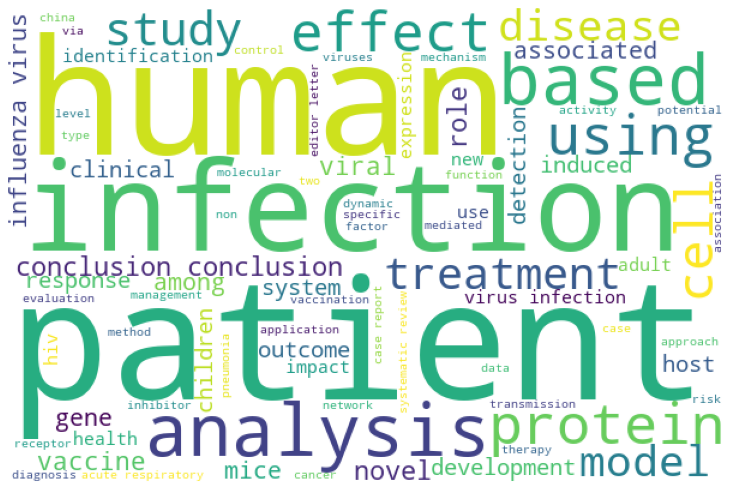

In [ ]:
# Wordcloud of most common words in titles of research papers:
show_WordCloud(covid19['title'].head(6000))

The word cloud above shows the most 80 common words appearing in the abstracts. "Respiratory syndrome", "syndrome coronavirus", "infectious disease", "acute respiratory", "influenza virus", "virus infection" and "sars cov" are some of the most common words, which makes a lot of sense, since the dataset we have are the combination over over 40,000 scholarly articles about COVID-19, SARS-CoV-2, and related coronaviruses.

### 3. Text preprocessing:

In [ ]:
# Filter to only use lituratures that are written in English:
covid19 = covid19[covid19['language'] == 'en']

# Filter to drop duplicates in body_text:
covid19.drop_duplicates(['body_text'], inplace=True)

In [ ]:
# Combine text features abstract and body_text into one feature full_text:
# covid19['full_text'] = covid19['abstract'] +" "+ covid19['body_text']

In [ ]:
# Create a new dataframe that only contain full_text feature:
covid19 = covid19[['title', 'abstract' , 'body_text']]
covid19.set_index('title', inplace=True) # reset title as index
covid19.head()

,abstract,body_text
title,,
Nitric oxide: a pro-inflammatory mediator in lung disease?,Inflammatory diseases of the respiratory tract...,Since its discovery as a biological messenger ...
Detection and characterization of horizontal transfers in prokaryotes using genomic signature,Horizontal DNA transfer is an important factor...,It is now widely admitted that actual genomes ...
"Comparisons of substitution, insertion and deletion probes for resequencing and mutational analysis using oligonucleotide microarrays",Although oligonucleotide probes complementary ...,Oligonucleotide microarrays are a powerful tec...
A Gene Encoding Sialic-Acid-Specific 9-O-Acetylesterase Found in Human Adult Testis,"Using differential display RT-PCR, we identifi...",Sialic acids are a diverse family of acidic ni...
Recombination Every Day: Abundant Recombination in a Virus during a Single Multi-Cellular Host Infection,Viral recombination can dramatically impact ev...,As increasing numbers of full-length viral seq...


In [ ]:
# Print out the shape of the new covid19 dataframe:
covid19.shape

(79162, 2)

#### Basic text cleaning

We'll use re(regular expression) module in order to preprocess our text. Specifically, we can use re to match and substitute special characters, numbers, spaces, etc. to clean article bodies before we apply any natural language processing technique.

In [ ]:
# Utility function to clean text:

def text_cleaner(text):
    text = re.sub(r'--',' ',text) #remove double dash
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)               
    text = re.sub(r'[-+=~_/\\|\^%:\.]{2,}',' ',text) #remove special characters and numbers
    text = re.sub(r'\\n',' ',text) #remove new line separation '\n'
    text = re.sub(r'\s*[\(\)0-9]+\s*', ' ', text,flags=re.M) #remove "words" that are nothing but spaces and digits, possibly with embedded parenthesis and dashes 
    text = ' '.join(text.split()) #spliting text
    text = text.lower() #lowercase all text
    return text

# Clean full_text feature using text_cleaner function:
covid19['abstract'] = covid19['abstract'].apply(text_cleaner)
covid19['body_text'] = covid19['body_text'].apply(text_cleaner)

In [ ]:
# Check the clean text:
covid19.head(10)

,abstract,body_text
title,,
Nitric oxide: a pro-inflammatory mediator in lung disease?,inflammatory diseases of the respiratory tract...,since its discovery as a biological messenger ...
Detection and characterization of horizontal transfers in prokaryotes using genomic signature,horizontal dna transfer is an important factor...,it is now widely admitted that actual genomes ...
"Comparisons of substitution, insertion and deletion probes for resequencing and mutational analysis using oligonucleotide microarrays",although oligonucleotide probes complementary ...,oligonucleotide microarrays are a powerful tec...
A Gene Encoding Sialic-Acid-Specific 9-O-Acetylesterase Found in Human Adult Testis,"using differential display rt-pcr, we identifi...",sialic acids are a diverse family of acidic ni...
Recombination Every Day: Abundant Recombination in a Virus during a Single Multi-Cellular Host Infection,viral recombination can dramatically impact ev...,as increasing numbers of full-length viral seq...
Torsional restraint: a new twist on frameshifting pseudoknots,mrna pseudoknots have a stimulatory function i...,the structure of an rna molecule is widely rec...
Towards standardization of RNA quality assessment using user-independent classifiers of microcapillary electrophoresis traces,while it is universally accepted that intact r...,purity and integrity of rna are critical eleme...
Draft versus finished sequence data for DNA and protein diagnostic signature development,"sequencing pathogen genomes is costly, demandi...",draft sequencing requires that the order of ba...
Sequence specific visual detection of LAMP reactions by addition of cationic polymers,background: development of a practical gene po...,loop-mediated isothermal amplification lamp is...


#### Text tokenization, lemmantization, and vectorization

The next steps in our process are tokenizing, lemmentizing, and vectorizing text data.

In natural language processing, each individual meaningful piece from a text is called a token, and the process of breaking up the text into these pieces is called tokenization. Tokens are generally words and punctuation. We may discard some tokens, such as punctuation and stop words, which we will be doing below, that we don't think add informational value. This is one of the essential steps in order to process the data from its original form (blocks of text or speech) into a form the computer can understand, then conduct analysis on the processed data.

Lemmantization, in addition to tokenization, can help further remove a little more noise from our data. Consider the words "think", "thought", and "thinking". They're related. They all share the same root word: the verb "think". Sometimes we want to focus on the fact that the act of thinking comes up a lot in data, and not have that information split across all the different forms of "think". This is where lemmantization comes into place as it can reduce each word to its root, or lemma.

![alt text][logo]

[logo]: https://miro.medium.com/max/3604/1*qQgnyPLDIkUmeZKN2_ZWbQ.png

In [ ]:
# Build funtion to tokenize and lemmatize text:
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000 # Only allow maximum length of 2,000,000 characters

def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.is_stop or word.is_punct or word.is_space or len(word)==1)]

# Build customize stop words:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table', '<k>', '-PRON-', '-$', '-a', '-a-', 
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'usually',
    r'\usepackage{amsbsy', r'\usepackage{amsfonts', r'\usepackage{mathrsfs', r'\usepackage{amssymb', r'\usepackage{wasysym', 'www', '\setlength{\oddsidemargin}', 
    r'\setlength{\oddsidemargin}{-69pt', r'\usepackage{upgreek', r'\documentclass[12pt]{minimal', r'\usepackage{amsmath', r'\documentclass{minimal'
]

# Mark them as stop words:
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

After all texts have been tokenized and lemmantized, we'll move on to convert tokens to vectors using **Tf-idf** vectorization technique. Why do we need this step? Think about it this way: this is a method to convert language into numbers that the computer can understand, because at the core of our computer, words can't be taken in as an input. 

So what is Tf-idf? Tf-idf stands for term frequency - inverse document frequency. 'Document frequency' counts how many sentences a word appears in.

Now let's weight the document frequency so that words that occur less often are more influential than words that occur a lot. This is very important when we try to understand and separate different documents. We will calculate the ratio of total documents (N) divided by document frequency(df), then take the log (base 2) of the ratio, to get our inverse document frequency number (idf) for each term (t). 

The next piece of information to consider for our weights is how frequently a term appears within a sentence. We can accomplish this by creating unique weights for each sentence that combine the term frequency (how often a word appears within an individual document) with the idf. 

The tf_idf score will be highest for a term that occurs a lot within a small number of sentences, and lowest for a word that occurs in most or all sentences.

Our vector representation of the text is referred to as a **Vector Space Model**. We can use this representation to compute the similarity between our sentences and a new phrase or sentence- this method is often used by search engines to match a query to possible results, which is what we are trying to implement! Now let's go ahead and vectorize our tokens using Tf-idf. This step takes about 25 minutes, so be patient!

In [ ]:
# Vectorize text and put the vectozied data into a new dataframe:
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                             min_df=25, #ignore terms that appear in less than 25 documents 
                             max_df=0.35, #ignore terms that appear in more than 35% of the documents(try between 0.3-0.5)
                             max_features=2**12) #set max_features limit to speed up execution. Can be omitted to include all features
data_vectorized = vectorizer.fit_transform(tqdm(covid19['clean_text']))

100%|██████████| 40213/40213 [20:53<00:00, 32.08it/s] 


In [ ]:
# Print out the shape of the vectorized dataset:
data_vectorized.shape

(40213, 4096)

In [ ]:
# Convert the vectorized text into array in preparation for clustering:
data_array = data_vectorized.toarray()

In [ ]:
data_array_df = pd.DataFrame(data_array)
data_array_df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.003937,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.009179,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021603,0.000000,0.04521,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40208,0.0,0.011093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
40209,0.0,0.013078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
40210,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.037335,0.008116,0.012859
40211,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


### 4. Text clustering

Clustering is all about organizing individual examples or observations into groups such that individuals in each group resemble fellow group members more than they do non-group members. This requires the ability to measure similarity. The reason why I want to cluster our data into groups is to explore how many potential topic we have in our set of litureratures. As viewers learn more about the different topics availabe in our dataset, they can quickly find what are of interest to them and look for relevant articles associated with that topic.

Here, we'll explore the k-means algorithm for clustering, the go-to, off-the-shelf algorithm for clustering data. K-means is a mathematically straightforward but computationally intensive algorithm. As the name suggests, k-means takes the number of clusters (k) as given and groups the observations into k clusters based on the nearest mean of each cluster. Below graph is a quick explanation of how K-means algorithm works.

![alt text][logo]

[logo]: https://ds055uzetaobb.cloudfront.net/brioche/uploads/y4KGN92h7r-screen-shot-2016-05-05-at-43007-pm.png?width=1200

Before jumping to clustering, we'll "prepare" our vectorized dataset using PCA. So what's PCA, and why do we use it? 

PCA stands for Principle Component Analysis, a technique used for dimensionality reduction. The reason for this is that by keeping a large number of dimensions with PCA, we don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for K-means. Our vectorized dataset has over 4000 features and over 40,000 records, which would be very computationally intensive without dimensionality reduction. Let's see how much we can reduce the dimensions while still keeping 90% variance. We will apply Principle Component Analysis (PCA) to our vectorized data.

In [ ]:
# Apply PCA for dimensionality reduction and keep 90% of variance
pca = PCA(n_components=0.9, random_state=123)
data_reduced= pca.fit_transform(data_array)
data_reduced.shape

(40213, 1900)

Notice that we reduced the dataset's dimension from 4,096 to only 1,899 dimensions while still keeping 90% of the data variance! This would make it significantly quicker to execute K-means. If your computer has a beefier processing unit however, feel free to skip this PCA step and try running K-means on the entire data_vectorized dataset.

Below, we'll apply K-means with a range of k from 2-20 in order to find the optimal clusters for our dataset. To do so, we'll use the elbow method that calculate the distortion score and graph the score against the number of k.

In [ ]:
# Run K-means with many different k to calculate the optimal k for our dataset:
distortions = [] #list to hold distortion scores
K = range(2, 31) #try k from 2-21 clusters
for k in K:
    k_means = MiniBatchKMeans(n_clusters=k, batch_size=100).fit(data_reduced)
    distortions.append(sum(np.min(cdist(data_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / data_reduced.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 2 clusters
Found distortion for 3 clusters
Found distortion for 4 clusters
Found distortion for 5 clusters
Found distortion for 6 clusters
Found distortion for 7 clusters
Found distortion for 8 clusters
Found distortion for 9 clusters
Found distortion for 10 clusters
Found distortion for 11 clusters
Found distortion for 12 clusters
Found distortion for 13 clusters
Found distortion for 14 clusters
Found distortion for 15 clusters
Found distortion for 16 clusters
Found distortion for 17 clusters
Found distortion for 18 clusters
Found distortion for 19 clusters
Found distortion for 20 clusters
Found distortion for 21 clusters
Found distortion for 22 clusters
Found distortion for 23 clusters
Found distortion for 24 clusters
Found distortion for 25 clusters
Found distortion for 26 clusters
Found distortion for 27 clusters
Found distortion for 28 clusters
Found distortion for 29 clusters
Found distortion for 30 clusters


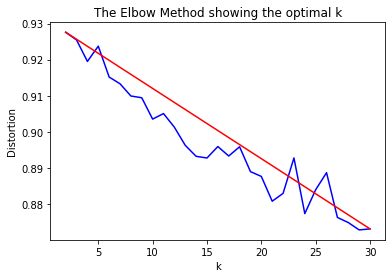

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow to find optimal k
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Wow! It looks like our distortion chart doesn't follow a smooth trend but peaks all over the places. This would make it hard to find out the optimal k. My observation was that k=15 is the end of the curve.

Below, I'll apply K-means with 15 clusters and visualize my clusters of points.

In [ ]:
# Apply K-means with k=10:
k = 15
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100)
y_pred = kmeans.fit_predict(data_reduced)
covid19['y'] = y_pred

In [ ]:
# pca = PCA(n_components=2, random_state=123)
# X_embedded = pca.fit_transform(data_array)
# X_embedded.shape

In [ ]:
# We'll use UMAP as a dimenstionality technique to visualize our clusters
import umap

X_embedded = umap.UMAP(n_neighbors = 25, 
                       min_dist = 0.2, 
                       n_components = 2,
                       metric='correlation').fit_transform(data_array)
X_embedded.shape

(40213, 2)

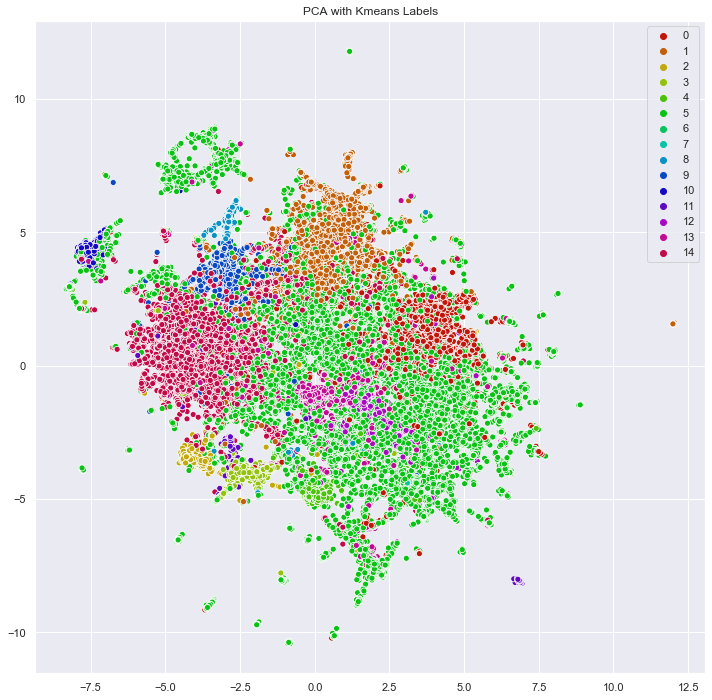

In [ ]:
# Seaborn settings
sns.set(rc={'figure.figsize':(12,12)})

# pick colors
palette = sns.hls_palette(15, l=.4, s=.9)

# Plot clusters:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('PCA with Kmeans Labels')
plt.savefig("pca_covid19.png")
plt.show()

### 5. Topic exploration with LSA, LDA, and NNMF

Let's move on to the final part of the project, which is exploring different topics and buiding the search engine for relevant research articles. In this section, we'll explore the differnt technique of topic modeling, compare these different technique, and create an actual widget to query or search for related documents.

But first, let's build some functions to link words to topic and extract top words associated with each topic.

In [ ]:
# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=15

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution
    
    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

The first topic modeling/text extraction technique we'll try is LSA(Latent semantic analysis). In LSA, the goal is to reproduce the tf-idf matrix using a smaller set of components, which we then call 'topics.' 

The Latent Semantic Analysis model is a theory for how meaning representations might be learned from encountering large samples of language without explicit directions as to how it is structured. Think of LSA as PCA but for text data.

To extract and understand patterns from the documents, LSA inherently follows certain assumptions:
   * Meaning of Sentences or Documents is a sum of the meaning of all words occurring in it. Overall, the meaning of a certain word is an average across all the documents it occurs in.
   * LSA assumes that the semantic associations between words are present not explicitly, but only latently in the large sample of language.

In [ ]:
# LSA

from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
covid19_lsa = lsa.fit_transform(data_vectorized)

components_lsa = word_topic(data_vectorized, covid19_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

One of the disadvantages of LSA is negative loading. For example, the word 'sick' can be featured in several topics. What does that mean? Are topics with negative loadings for 'sick' topics having to do with the opposite of sick(healthy), or are they just totally unrelated to sick(such as turnips)? There's no way to know without examining every topic individually.

The point of this is to show that LSA is useful as a data reduction tool, but if you want to be able to understand how the topics relate to the words in your corpus, it is not the best technique because of its use of negative loadings. Unfortunately, negative loadings are an inherent part of LSA. Fortunately, there are other methods better suited to dealing with sparse, non-negative matrices.

Another topic modeling technique is LDA(Latent Dirichlet Allocation). Latent Dirichlet Allocation is a Bayesian implementation that includes sparse Dirichlet priors for estimating the probability that a topic will be in a document ( 𝑃(𝑡|𝑑) ) and the probability that a word will be in a topic ( 𝑃(𝑤|𝑡) ). LDA is computationally intensive to model, but can be more accurate than LSA, with less proneness to overfitting. The model also generalizes to new documents, and so is useful in a situation where the corpus is expected to expand with time.

Let's implement LDA to our dataset.

In [ ]:
# Use Latent Dirichlet allocation(LDA) as dimensionality reduction technique:
lda = LDA(n_components=ntopics, # Reduce to only 8 components 
          doc_topic_prior=None, 
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

# covid19_lda = lda.fit(data_vectorized)
covid19_lda = lda.fit_transform(data_vectorized)

components_lda = word_topic(data_vectorized, covid19_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

In [ ]:
covid19_lda.shape

(40213, 15)

Latent variables are all very nice, but the need to model such a large number of unknowns makes methods like LDA computationally unwieldy. What if we could have the elegant simplicity of PCA but without the hassle of uninterpretable negative loadings? That's where Non-Negative Matrix Factorization (NNMF) comes in.

Like PCA, NNMF is searching for two matrices that, when multiplied together, result in the original data matrix- in this case, the tf-idf matrix.

Unlike PCA, however, in NNMF we apply the constraint that all three matrices (the original and the two new ones) must contain no negative values.

In [ ]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
covid19_nmf = nmf.fit_transform(data_vectorized)

components_nmf = word_topic(data_vectorized, covid19_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [ ]:
# For each topic, we list the ten most-relevant words according to each method:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                LSA               LDA           NNMF
0      mouse 518.61   hospital 188.01   peptide 12.0
0     vaccine 471.6     covid- 136.39   domain 10.87
0      child 378.49       sars 123.74      nsp 10.52
0       sars 332.23      staff 111.56   residue 9.72
0         cd 327.91       nurse 105.5    fusion 8.69
0  pneumonia 308.15     contact 99.54  sars-cov 7.51
0   hospital 308.04  healthcare 98.45        mm 6.59
0       lung 303.82        hcws 98.13     amino 6.28
0     public 278.93      worker 96.36    mutant 6.28
0   epidemic 277.11  participant 94.7     mouse 6.21
Topic 1:
                   LSA              LDA                NNMF
1         child 244.88       bat 172.05        covid- 38.39
1      hospital 236.78  mers-cov 170.72        public 25.74
1        covid- 216.43      camel 84.72      epidemic 21.56
1        public 194.68   sars-cov 51.41      pandemic 20.43
1     pneumonia 168.54       mers 43.88      hospital 19.41
1      epidemic 160.79        cov 37.82

Now let's examine sparsity by looking at the distributions of loadings for the words 'mers-cov', 'covid-', 'pneuminia', 'child' and 'cd' across the methods.

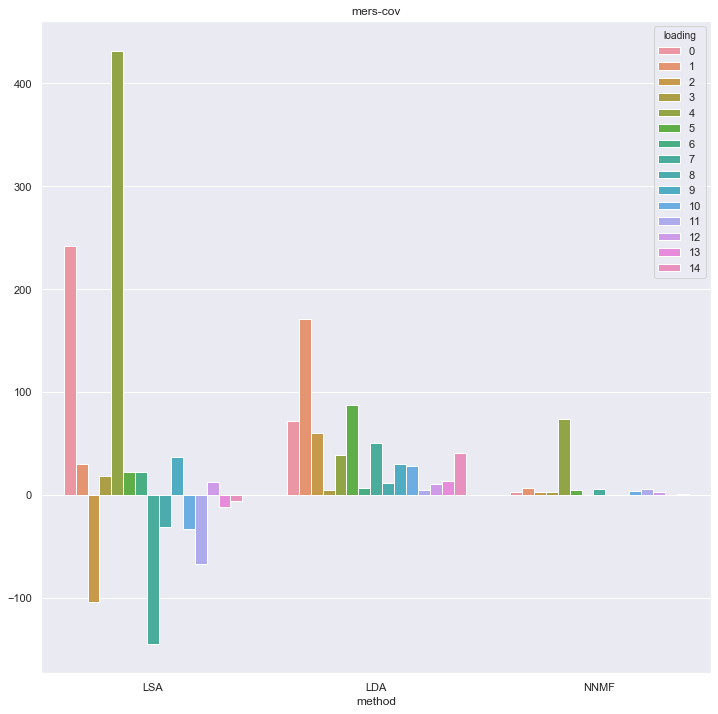

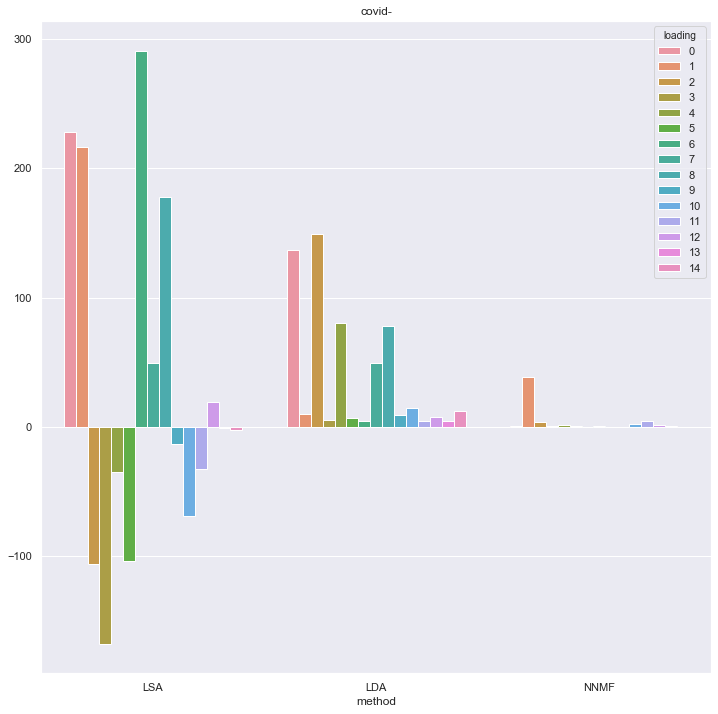

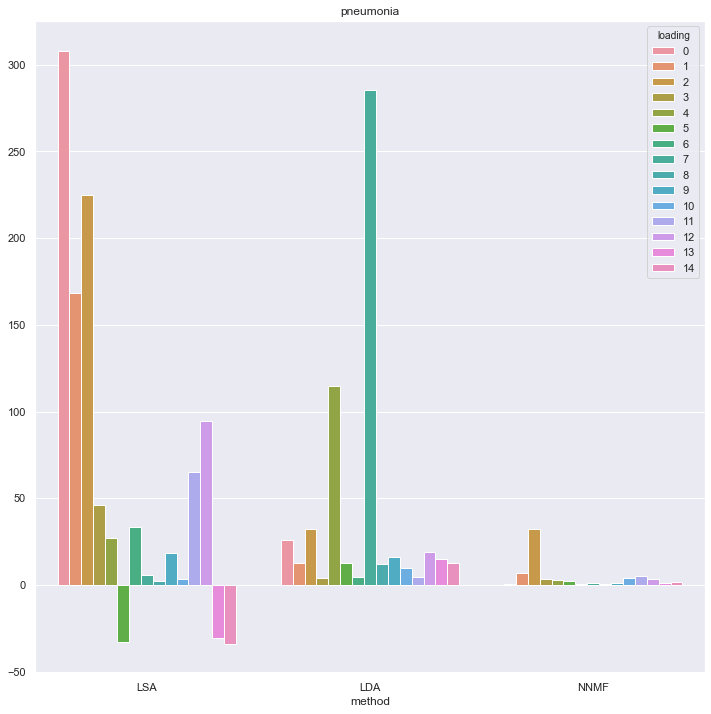

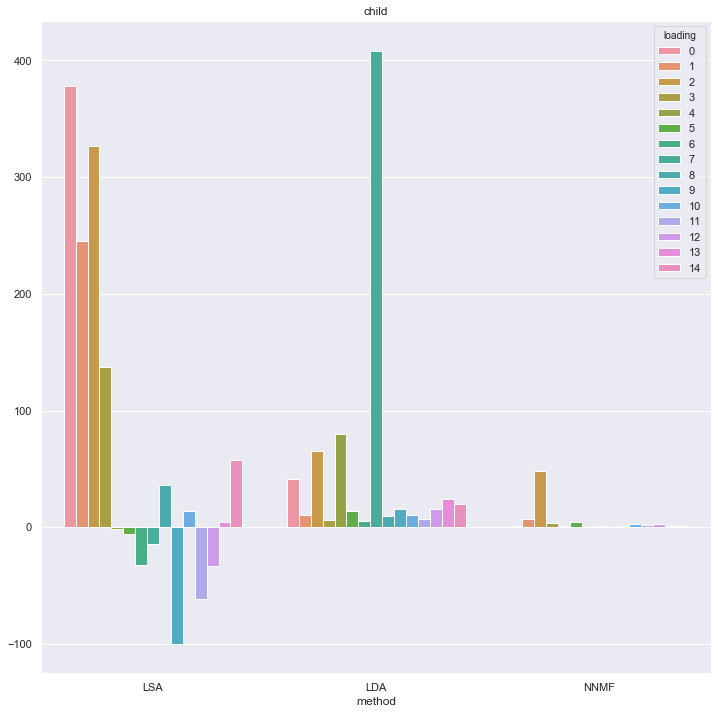

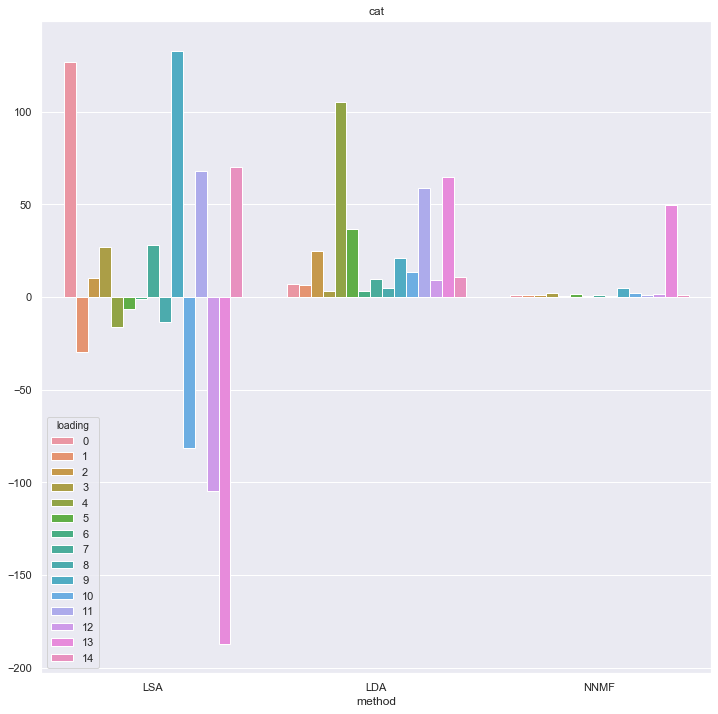

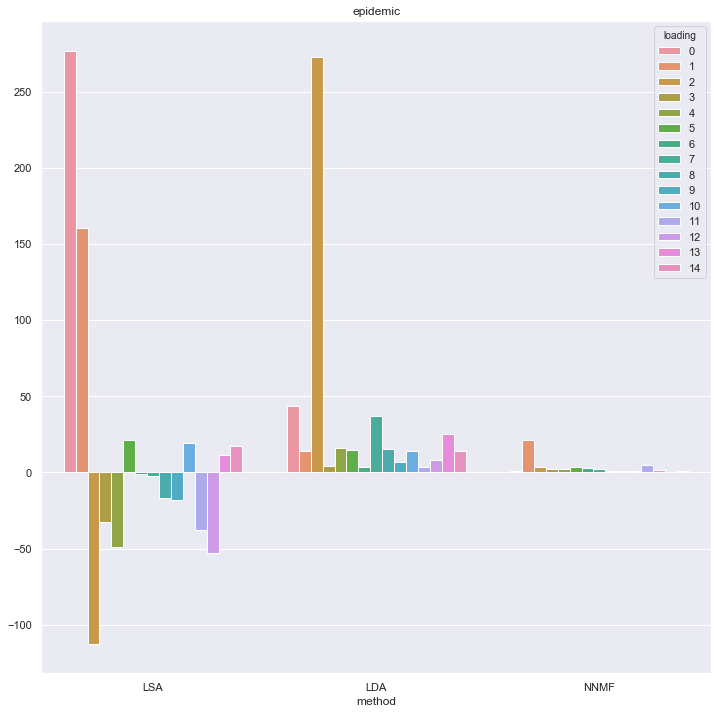

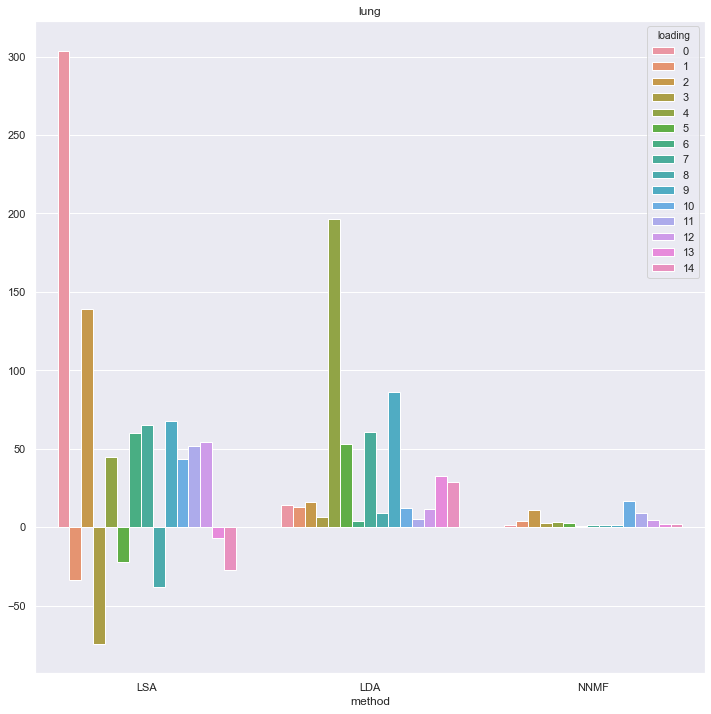

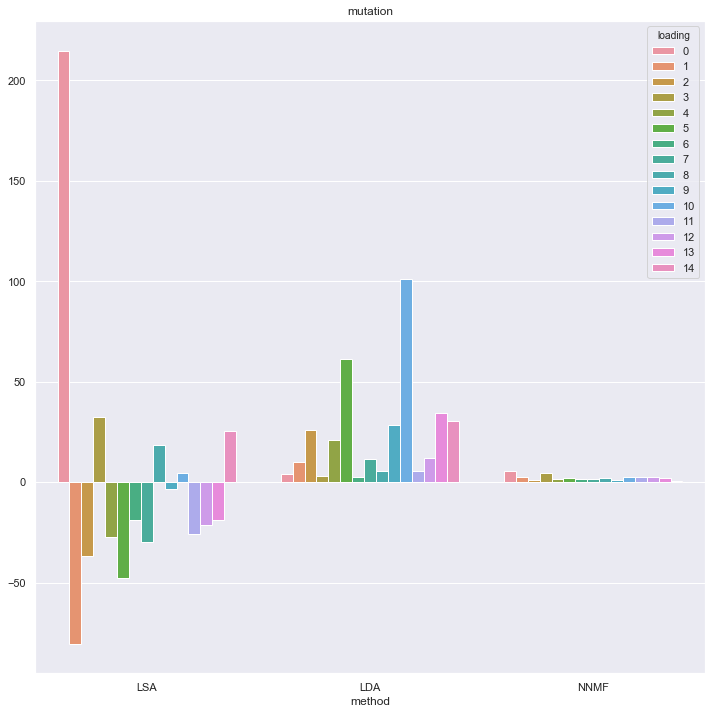

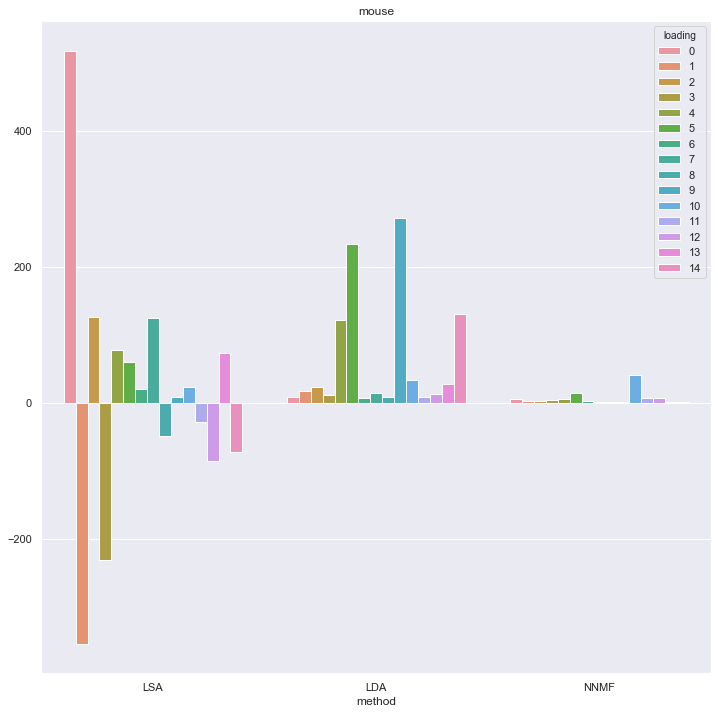

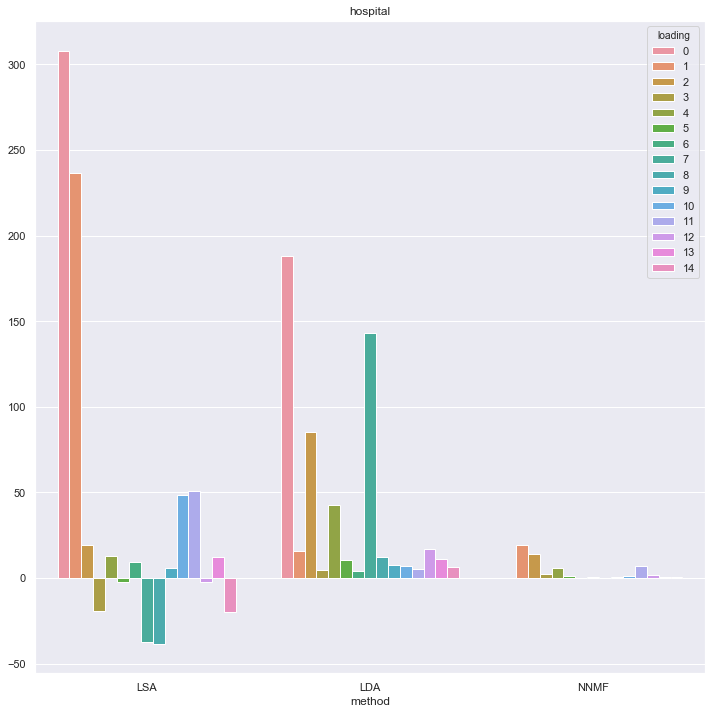

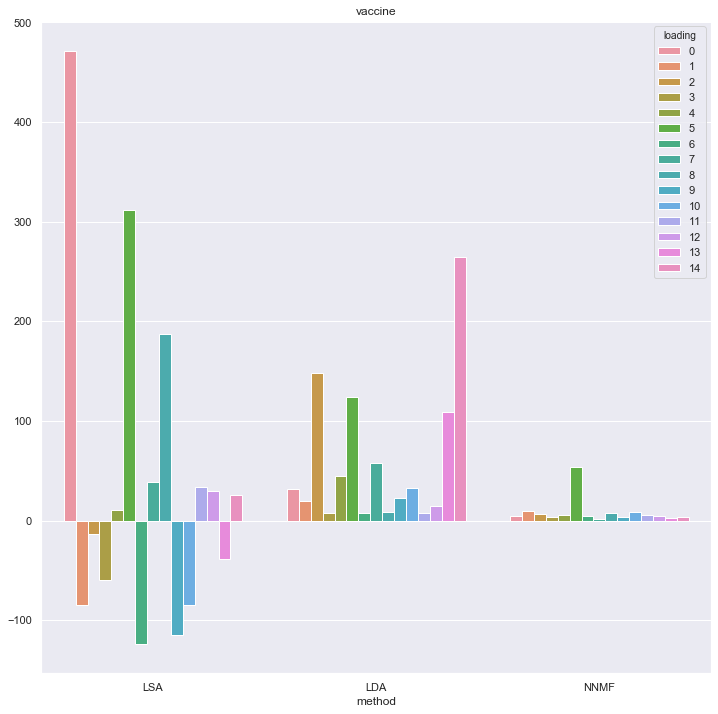

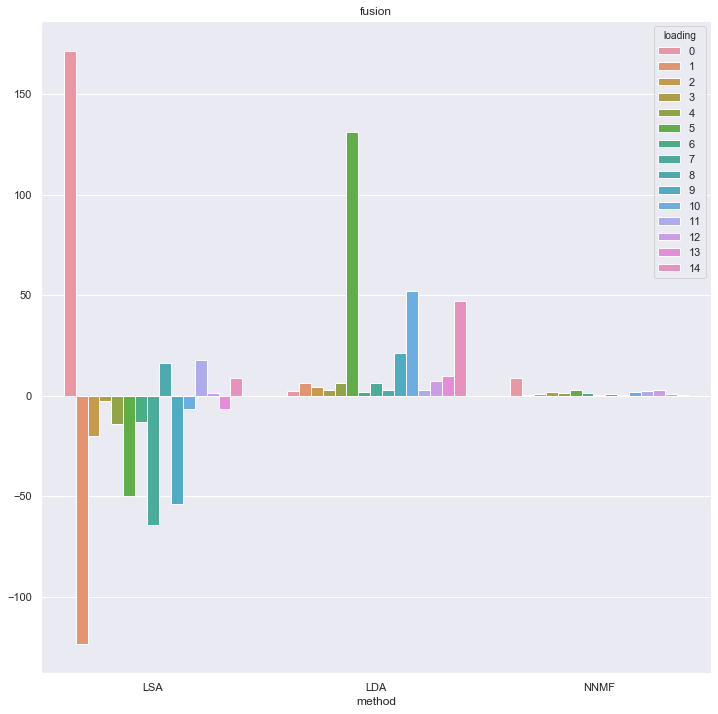

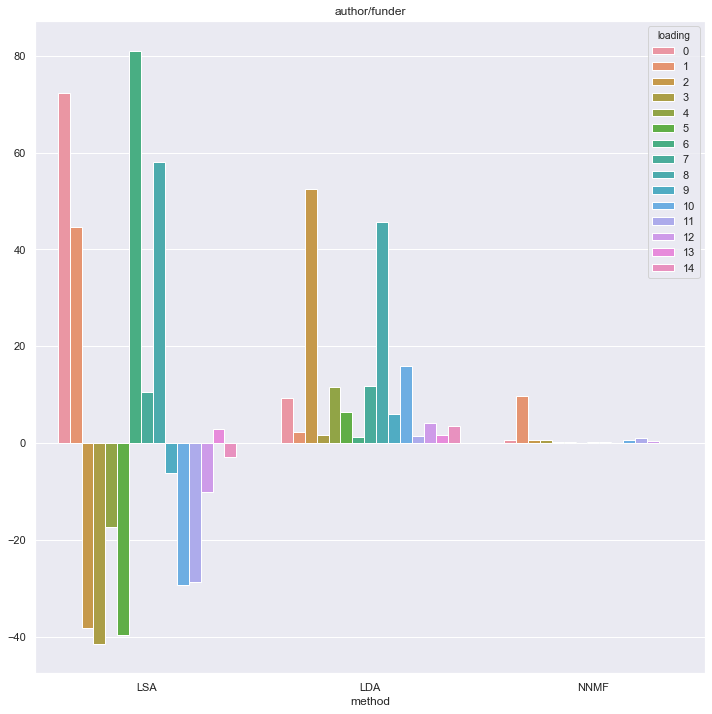

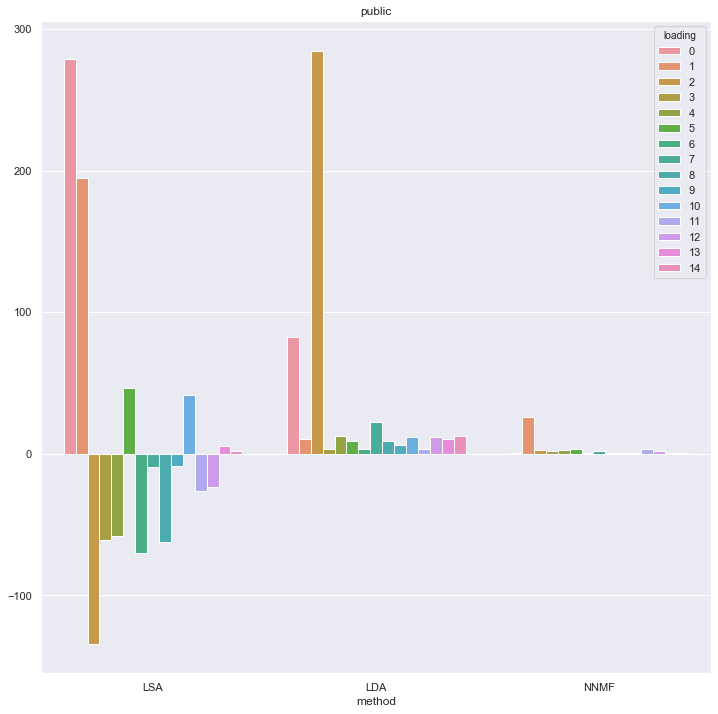

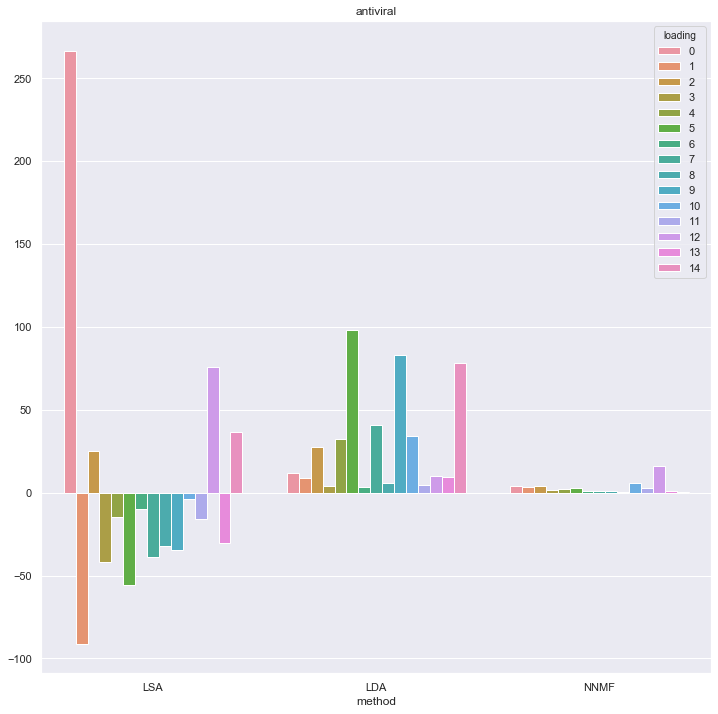

In [ ]:
# The words to look at.
targetwords=['mers-cov','covid-','pneumonia','child', 'cat', 'epidemic', 'lung', 'mutation',
             'mouse', 'hospital', 'vaccine', 'fusion', 'author/funder', 'public', 'antiviral']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 15, axis=0)
wordloadings['loading']=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


A number of things are clear. First, some topics are shared, though the order of topics varies. And second, the content of some of the topics varies considerably across methods. This is a clear argument for using multiple methods when exploring topics. 

Notice that LSA has some negative loading for words, and NNMF has very low loading? It looks like LDA gives us the most consistent result. Let's apply LDA and build the search engine with the codes below.

### 6. Build search widget

In this section, we'll build a search widget that is more user friendly. Essentially, it will allows us to enter our search query into a box, and related articles will be spinned out. We'll use cosine metric to calculate the similarity between viewer's query and different literatures in order to find relevant ones.

So what's cosine similarity? It is essentially a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Cosine similarity is advantageous because it can determine how similar the documents are irrespective of their sizes.

Let's go ahead and create a function to calculate and get the nearest documents based on cosine metric.

In [ ]:
# Create function to calcuate and get nearest documents based on cosine-similarity metric:
def get_k_nearest_docs(doc_dist, k=5, get_dist=False):
    distances = pd.DataFrame(covid19_lda).apply(lambda x: cosine(x, doc_dist), axis=1) # calulate similarity based on cosine metric
    k_nearest = distances[distances != 0].nsmallest(n=k).index # get k nearest documents
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k) 
        return k_nearest, k_distances
    else:
        return k_nearest

In [ ]:
# Create function to pull related research papers based on a listed task:
def relevant_articles(tasks, k=5):
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_vectorized = vectorizer.transform(tasks)# Vectorize task list
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized)) # Perform lda on vectorized task list

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], k) # Recommend papers based on task
        recommended = covid19.iloc[recommended]

        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' for l, n in recommended[['url','title']].values])
        display(HTML(h)) # Attach url link so we can open and read the paper

In [ ]:
# Test: query 5 related research papers on vaccines & therapeutics:
task = ["Seasonality of transmission", 
       "Immune response and immunity", 
       "Implementation of diagnostics"]

relevant_articles(task)

Seasonality of transmission


Immune response and immunity


Implementation of diagnostics


In [ ]:
# Create a widget to show relevant articles:
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px'))
    
    kWidget = widgets.IntSlider(value=5, description='k', max=20, min=1, layout=Layout(width='30%'))
    button = widgets.Button(description="Search")
    display(VBox([HBox([kWidget], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))
    
    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value)

    button.on_click(on_button_clicked)

In [ ]:
relevant_articles_for_text()

risk factors


### 7. Conclusion:

In this notebook, we implement an automated search engine that allows readers to search for relevant articles related to their topics of interest. The solution allows people who are interested in learning more about COVID-19 to filter through over 40,000 articles to find those that are relevant to their search query. This solution arises from not only the need to understand more about the pandemic we are currently living in, but also the need to prevent fake news and unreliable data sources.

Throughout this kernal, we applied a combination of data cleaning, unsupervised learning, and natural language processing techniques to discover different underlying topics within the pool of literatures, and created a search engine based on document similarity.

We started out with importing python libraries and exploring the data at hand using different exploratory data analysis technique, including statistical analysis and visualization of data. We then separated and prepared text data with standard text cleaning using regular expression module. After that, we transformed text data into a computer recognizable form of information using tokenization, lemmantization, and vectorization method. We used K-means and UMAP to cluster our litureratures to understand the search papers and find potential topics available within the underlying data. Finally, we built a widget to query research papers based on cosine similarity metric.

There are plenty of applications for this engine. It can be applied in the real world in many different situations, for example, a search engine(similar to Google search) that filters to show only relevant news/articles. Imagine information services like EBSCO, who provide research databases, can take advantage of a system like this to allow viewers to search for related publications for a topic of interest. For a company, imagine this type of engine can be used concurrently with a chatbot to help customer navigate and answer customer's question by navigating and providing appropriate information.

A couple of drawbacks from this project that can be further considered for improvement:
   * Obviously, the dataset we used was very large, and it took a while for the entire notebook to run. If this model is to be deployed and new data could continuously flow in through the data pipeline, we will definitely want to consider cloud platform in order to handle the increasingly intensive execution of the engine.
   * A lot of the data was trimed down (for example, a cap on body_word_count, a cap on max_features for tf-idf vectorizer, or the application of PCA before running K-means) in order to speed up the notebook since my local machine is quite small. This also comes with a less robust search enigne. 
   * Hyper-parameters for tf-idf, LSA, LDA, and NNMF can be further fine-tuned. We can for example, try bigram or trigram when processing text data, which comes with the expense of computational complexity and longer execution time.
   * Instead of using LDA, maybe we an try word2vec to find topic similarity. The conceptual difference is that LDA creates vector representations of sentences based on the words in them, while word2vec creates representations of individual words, based on the words around them.
